**1. Import the MNIST dataset from keras**

Using TensorFlow backend.


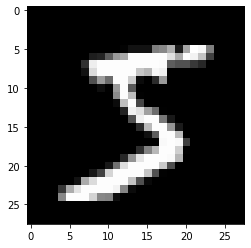

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random

# Download the MNIST dataset from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Make sure images are loaded by plotting at least 1 digit.
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.show()

**2. one hot encode the output variable. Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])**

In [0]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

**3. Normalize the values in each pixel to have the value of each pixel in the range of 0 to 1.**

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape the dataset into 3 dimension, with lenght, width and channels to 1 (RGB)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

**4. Augment dataset to include additional dataset by artificially altering the training data slightly, like scaling in and out etc. Training on this dataset helps avoid over fitting. Lets use Keras for data augmentation**

In [0]:
datagen = ImageDataGenerator(zoom_range=0.5, width_shift_range=0.05, height_shift_range=0.05)
datagen.fit(X_train)

**5. Lets define Dense Layer with forward propagation and backward propagation**

In [0]:
class Layer:
    def __init__(self, in_neurons, out_neurons, dropout=0.2, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(in_neurons, out_neurons) * 0.01
        self.biases = np.zeros(out_neurons)

    def forward_propagation(self, input_activations):
        activations = np.matmul(input_activations, self.weights) + self.biases
        return activations

    def backward_propagation(self, input_activations, grad_output):
        grad_input = np.dot(grad_output, np.transpose(self.weights))

        # Gradient with Weights
        grad_weights = np.transpose(np.dot(np.transpose(grad_output), input_activations))
        # Gradient with Biases
        grad_biases = np.sum(grad_output, axis=0)

        # Stochastic Gradient Descent.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

**6. Lets define Relu Layer with forward propagation and backward propagation**

In [0]:
class ReLu:
    @staticmethod
    def forward_propagation(input_activations):
        return (input_activations > 0) * input_activations

    @staticmethod
    def backward_propagation(input_activations, grad_output):
        return (input_activations > 0) * grad_output

**7. Lets define Dropout Layer which takes dropout_ratio and makes those neurons activation zero based on the ratio**

In [0]:
class Dropout:
    @staticmethod
    def generate_dropout_mask(size, dropout_ratio):
        zeros_size = int(size * dropout_ratio)
        zeros = np.zeros(zeros_size)
        ones = np.ones(size - zeros_size)
        dropout_mask = np.asarray(zeros.tolist() + ones.tolist())
        random.shuffle(dropout_mask)
        return dropout_mask

    def __init__(self, size, dropout_ratio=0.20):
        self.dropout_mask = Dropout.generate_dropout_mask(size, dropout_ratio)

    def forward_propagation(self, input_activations):
        return np.multiply(input_activations, self.dropout_mask)

    def backward_propagation(self, input_activations, grad_output):
        return np.multiply(grad_output, self.dropout_mask)

**8. Lets define the neural network with 3 Dense Layes, 2 ReLu layers and 2 Droput layers.**

In [0]:
neural_network = [
    Layer(X_train.shape[1] * X_train.shape[2], 200),
    Dropout(200, 0.20),
    ReLu(),
    Layer(200, 100),
    Dropout(100, 0.10),
    ReLu(),
    Layer(100, 10)
]


**9. Method to calculate the error using softmax function.**

In [0]:
def softmax_error(out_activations, y):
    softmax = np.exp(out_activations) / np.exp(out_activations).sum(axis=-1, keepdims=True)
    return softmax - y


**10. Calculate the weights of all neurons in network using the forward propagation logic corresponging to each layer.**

In [0]:
def get_activations(X):
    # Get the layer activations
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    activations = []
    for level in range(len(neural_network)):
        next_activations = neural_network[level].forward_propagation(X)
        activations.append(next_activations)
        X = next_activations
    return activations

**11. Training the model**

In [0]:
def train(X, y):
    activations = get_activations(X)
    output_activations = activations[-1]

    loss = softmax_error(output_activations, y)
    for i in range(1, len(neural_network)):
        network = neural_network[len(neural_network) - i]
        loss = network.backward_propagation(activations[len(neural_network) - i - 1], loss)

      
def predict(X):
    out_activations = get_activations(X)[-1]
    return out_activations.argmax(axis=-1)


def train_datagen(datagen, total_iterations):
  for iteration in range(total_iterations):
      total_mini_batch_trainings = 100
      for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=8):
          train(X_batch.reshape(-1, X_batch.shape[1], X_batch.shape[2]), y_batch)
          total_mini_batch_trainings -= 1
          if total_mini_batch_trainings == 0:
              break
      print("=====================Iteration: {}=====================".format(iteration))
      train_result = [np.mean(predict(X_train) == y_train.argmax(axis=-1))]
      print("Train accuracy: {}%".format(train_result[-1] * 100))
      test_result = [np.mean(predict(X_test) == y_test.argmax(axis=-1))]
      print("Test accuracy: {}%".format(test_result[-1] * 100))

# Training the model with Augumented data generated
train_datagen(datagen, 110)

=====================Iteration: 0=====================
Train accuracy: 9.863333333333333%
Test accuracy: 9.58%
=====================Iteration: 1=====================
Train accuracy: 16.941666666666666%
Test accuracy: 17.18%
=====================Iteration: 2=====================
Train accuracy: 32.85333333333333%
Test accuracy: 33.2%
=====================Iteration: 3=====================
Train accuracy: 45.535%
Test accuracy: 46.46%
=====================Iteration: 4=====================
Train accuracy: 53.978333333333325%
Test accuracy: 55.65%
=====================Iteration: 5=====================
Train accuracy: 54.49666666666667%
Test accuracy: 54.92%
=====================Iteration: 6=====================
Train accuracy: 59.40833333333333%
Test accuracy: 60.23%
=====================Iteration: 7=====================
Train accuracy: 63.48666666666667%
Test accuracy: 64.71000000000001%
=====================Iteration: 8=====================
Train accuracy: 52.38666666666667%
Test accuracy

In [0]:
# Training the model without skewing the digits
datagen_plain = ImageDataGenerator(zoom_range=0, width_shift_range=0, height_shift_range=0)
train_datagen(datagen_plain, 20)

=====================Iteration: 0=====================
Train accuracy: 92.59166666666667%
Test accuracy: 92.73%
=====================Iteration: 1=====================
Train accuracy: 93.45%
Test accuracy: 93.27%
=====================Iteration: 2=====================
Train accuracy: 91.64333333333333%
Test accuracy: 91.75999999999999%
=====================Iteration: 3=====================
Train accuracy: 93.05499999999999%
Test accuracy: 93.41000000000001%
=====================Iteration: 4=====================
Train accuracy: 93.26333333333334%
Test accuracy: 93.56%
=====================Iteration: 5=====================
Train accuracy: 90.95333333333333%
Test accuracy: 91.06%
=====================Iteration: 6=====================
Train accuracy: 92.93166666666667%
Test accuracy: 92.74%
=====================Iteration: 7=====================
Train accuracy: 92.43333333333334%
Test accuracy: 92.42%
=====================Iteration: 8=====================
Train accuracy: 92.48666666666666%
Te

**12. Test results**

In [0]:
from sklearn.metrics import confusion_matrix

y_pred = predict(X_test)
print('confusion matrix for the real test set:\n', confusion_matrix(y_test.argmax(axis=-1), y_pred))
final_test_accuracy = np.mean(predict(X_test) == y_test.argmax(axis=-1)) * 100
print("Final Test Accuracy: {}%".format(final_test_accuracy))

confusion matrix for the real test set:
 [[ 957    0    4    1    0   12    2    0    2    2]
 [   0 1112    7    5    2    1    3    0    3    2]
 [  13    2  946   33    9    4    2    7   13    3]
 [   0    0    8  967    0   18    0    3    6    8]
 [   4    1    2    0  945    2    6    0    1   21]
 [   2    0    3   23    6  843    2    1    7    5]
 [  20    4    6    2   15   31  871    0    8    1]
 [   2   12   15   16   23    6    0  879    0   75]
 [   3    0   13   49   12   38    3    1  839   16]
 [   4    3    2   11   60    6    0    2    2  919]]
Final Test Accuracy: 92.78%
